In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft
from IPython.display import Audio, display
from zvon import *

In [2]:
def show(y):
    x = range(len(y))
    print('min:', np.min(y), ', max:', np.max(y))
    plt.plot(x, y)
    plt.show()

def log10(x):
    return np.log10(x.clip(min=1e-30))

def show_fft(y, max_freq=15000):
    fft_y = 20 * log10(np.abs(fft(y)) / SR)
    plt.plot(range(len(y)), fft_y)
    plt.xlim(0, max_freq)
    plt.ylim(-120, 0)
    plt.show()

def save_audio(y, filename='test.wav'):
    audio = Audio(y, rate=SR)
    display(audio)
    open(filename, "wb").write(audio.data)

def save_audio_stereo(y, filename='test.wav'):
    left, right = np.array([v[0] for v in y]), np.array([v[1] for v in y])
    save_audio([left, right], filename)

In [3]:
NOTES = {
    'c-': 0,
    'c#': 1,
    'd-': 2,
    'd#': 3,
    'e-': 4,
    'f-': 5,
    'f#': 6,
    'g-': 7,
    'g#': 8,
    'a-': 9,
    'a#': 10,
    'b-': 11
}

def note_freq(note):
    n, o = note[:2].lower(), int(note[2])
    return midi_freq(NOTES[n] + 12 * (o + 2))

def change(stack, params):
    for box_idx, param, val1, val2 in params:
        box = stack[box_idx]
        box.change(box.state, param, val1, val2)

def play_song(channels, song, tick):
    samples = []
    for row in song:
        for chan, params in zip(channels, row):
            if chan.is_on:
                change(chan.stack, params)
        samples += mix_process(channels, len(row), tick, 1)
    return samples

min: -0.97983624099694 , max: 0.9780235343732654


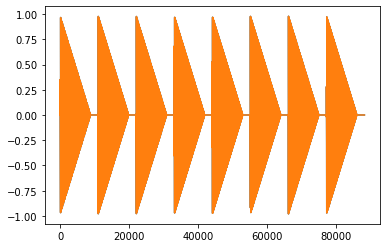

In [4]:
class Test:
    __slots__ = ('p', 'e', 'freq', 'vol')

def test_init(s):
    s.p = Phasor()
    s.e = Env()
    s.freq = 0
    env_init(s.e, [sec(0.001), sec(0.2)], 0, [1, 0])
    phasor_init(s.p)

def test_change(s, param, val1, val2):
    if param == 'ZV_NOTE_ON':
        s.freq = val1
        s.vol = val2
        env_reset(s.e)

def test_next(s, l):
    y = saw(phasor_next(s.p, s.freq), 0.7) * s.vol * env_next(s.e)
    return y

def test_node_init(n):
    n.change = test_change
    n.next = test_next
    n.state = Test()
    n.is_stereo = False
    test_init(n.state)

mix_init(Channels)
chan_push(Channels[0], test_node_init)
chan_set(Channels[0], True, 1, 0)

def note_on(box_idx, note, vol):
    return (box_idx, 'ZV_NOTE_ON', note_freq(note), vol)

song = [
    [(note_on(0, 'c-3', 1),)],
    [(), ()],
    [(note_on(0, 'g-3', 1),)],
    [(), ()],
    [(note_on(0, 'e-3', 1),)],
    [(), ()],
    [(note_on(0, 'g-3', 1),)],
    [(), ()],
    [(note_on(0, 'c-4', 1),)],
    [(), ()],
    [(note_on(0, 'g-3', 1),)],
    [(), ()],
    [(note_on(0, 'e-3', 1),)],
    [(), ()],
    [(note_on(0, 'g-3', 1),)],
    [(), ()]    
]

y = play_song(Channels, song, sec(1/8))

show(y)
save_audio_stereo(y)